# The grid as an object

In this notebook, the grid object and the xarray dataset and data frame are explained and demonstrated with a few illustrating examples. 

---

grid.py contains one class, `Grid()`. 

We import some standard Python packages: 

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Eventually, install exatra dependecies for some functionality in coming tutorials:

In [33]:
#!pip3 install "dask[array]" --upgrade --user
#!pip3 install pyepsg --user

In [34]:
import sys
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt

In [35]:
#Depending on where the grid.py is located, you might call it from its path

sys.path.append('..') # Because tutorials are in a sibling directory and import beyond top-level package is blocked

# ... or use your Python path or present working directory:
from agrid.grid import Grid
# We also want some other useful functions
from agrid.acc import download

print(Grid)

#Check if some modules have been imported. sys is imported with agrid
print('numpy' in sys.modules, 
      'rasterio' in sys.modules, 
      'bokeh' in sys.modules, sep='\n') #(bokeh is imported in a method)


<class 'agrid.grid.Grid'>
True
True
False


We can now define a grid object. 

Each grid is a model frame with a defended, regular$^1$ spatial extent. The frame is generated when the object is initiated and resolution, coordinate system and coordinates etc are defined. 

The class defines an object. Let's say that we would like to develop a gridded model of the African continent. We want to use WGS 1984 (EPSG:4326), and a resolution of $0.5^\circ$. We define the extent as left, right, up, down in the units of the projection, degrees in this example. 

When initiating the object, a number of instance variables are defined. These contains the size of the grid, the name of the grid and the affine transform of the grid. (`use_dask` will be explained later). 

---
1. This will be updated in later versions. 

In [36]:
africa = Grid(crs=4326, left=-20, down= -45, right=55, up=40, 
              res = (0.5, 0.5), use_dask=False)

print(africa)

With the object, variables are generated, both class variables and instance variables. 

E.g the class variable verbose is a switch for print statements from the functions. Instance variables `nx`, `ny`, `nn`, `shape3` are integers and tuples that conveniently gives to fundamental size of the grid. `transform` is the affine transform. 

In [37]:
# Class variables
print(Grid.verbose) # Switch for print commands

# Instance variables
print(africa.ny, africa.nx, africa.nn, africa.shape3)
print(africa.transform)

False
170 150 (170, 150) (170, 150, 5)
| 0.50, 0.00,-20.00|
| 0.00, 0.50,-45.00|
| 0.00, 0.00, 1.00|


Note that dimensions are given as y, x, not x, y. This was a tricky decision to make. The reasoning is, that numpy arrays are given as rows-columns. By given the y dimension first, we are consistent through the project, but I'd expect that this might cause confusion. I'm happy for suggestions of how to simplify the indexing. Indexing is, however, less a problem when we move to the main feature of the grid object, the xarray dataset. 

---

The xarray dataset is the core of the model and is created already populated with dimensions that contains coordinates. X, Y and Z are (in this example) the three spatial dimensions. X and Y are set to the selected projection (epsg:4326) and is hence in degrees. 

Xarray dataset can be a bit tricky to grasp. There is good information at [xarray project page](http://xarray.pydata.org/en/stable/api.html) where there are a number of code examples. As always, [Stack overflow](https://stackoverflow.com/search?q=xarray) is a good resource as well. Think about it as Pandas, but multidimensional. It can also be understood as a very organized way to arrange numpy arrays in relation to each other. Another approach, if you are familiar with [NetCDF](https://www.unidata.ucar.edu/software/netcdf/), xarray has a similar internal structure. 

For our use, each grid object contains one dataset e.g. `africa.ds`. The dataset contains a number of data frames that are linked to coordinates in different dimensions. The dataset also contain attribute data. 

In [38]:
print(africa.ds)

<xarray.Dataset>
Dimensions:  (RGB: 3, X: 150, X_edge: 151, Y: 170, Y_edge: 171, Z: 5, Z_edge: 6)
Coordinates:
  * X        (X) float32 -20.0 -19.496645 -18.993288 ... 53.99329 54.496643 55.0
  * Y        (Y) float32 -45.0 -44.49704 -43.994083 ... 38.994083 39.49704 40.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * X_edge   (X_edge) float32 -20.25 -19.746666 -19.243334 ... 54.746666 55.25
  * Y_edge   (Y_edge) float32 -45.25 -44.74706 -44.244118 ... 39.74706 40.25
  * Z_edge   (Z_edge) float64 -4e+03 4e+03 1.2e+04 2.8e+04 1.95e+05 5.05e+05
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
    YV       (Y, X) float32 -45.0 -45.0 -45.0 -45.0 ... 40.0 40.0 40.0 40.0
    lat      (Y, X) float32 -45.0 -45.0 -45.0 -45.0 ... 40.0 40.0 40.0 40.0
    lon      (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
Data variables:
    *empty*


We use standard Python / numpy methods to generate or process data and assign to the dataset. Here we generate a 2D array of data points and assign it to the Y and X coordinates of the grid. 

In [39]:
random_data = np.random.random(africa.nn)
africa.ds['RANDOM'] = (('Y', 'X'), random_data)

The object contains a number of functions to import, process, export and visualize data in the grid. More about import functions in next tutorial. For now, we download a global polygon shape file. We add an element to the meta data. 

In [40]:
download('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_land.zip', 
        '../data/ne_10m_land.zip', 
        meta_dict={'Type' : 'Land Polygons'})

Content:  text/html; charset=UTF-8
File ../data/ne_10m_land.zip already exists.


['ne_10m_land.README.html',
 'ne_10m_land.VERSION.txt',
 'ne_10m_land.cpg',
 'ne_10m_land.dbf',
 'ne_10m_land.prj',
 'ne_10m_land.shp',
 'ne_10m_land.shx']

The shape file can be used to generate a Boolean raster. The function `assign_shape` in the object ´africa´ reads a shape file and rasterises it. Here, all polygons are assigned `True` as there is an FID attribute. This might take some time, as the vector layer is very large. This will also generate some warnings, as no vector file is perfect... 

Note again, the order of dimension: Y, X. 

In [41]:
# Using standard xarray assignment:
africa.ds['LAND'] = (('Y', 'X'), 
                     -1 < africa.assign_shape('../data/ne_10m_land.shp', 'scalerank') )

/Users/tobias_stal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


Now, if we look at our dataset, we have two data variables, or frames. RANDOM and LAND. Both have an extent along the X and Y axes. 

In [42]:
africa.ds

<xarray.Dataset>
Dimensions:  (RGB: 3, X: 150, X_edge: 151, Y: 170, Y_edge: 171, Z: 5, Z_edge: 6)
Coordinates:
  * X        (X) float32 -20.0 -19.496645 -18.993288 ... 53.99329 54.496643 55.0
  * Y        (Y) float32 -45.0 -44.49704 -43.994083 ... 38.994083 39.49704 40.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * X_edge   (X_edge) float32 -20.25 -19.746666 -19.243334 ... 54.746666 55.25
  * Y_edge   (Y_edge) float32 -45.25 -44.74706 -44.244118 ... 39.74706 40.25
  * Z_edge   (Z_edge) float64 -4e+03 4e+03 1.2e+04 2.8e+04 1.95e+05 5.05e+05
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
    YV       (Y, X) float32 -45.0 -45.0 -45.0 -45.0 ... 40.0 40.0 40.0 40.0
    lat      (Y, X) float32 -45.0 -45.0 -45.0 -45.0 ... 40.0 40.0 40.0 40.0
    lon      (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
Data variables:
    RANDOM   (Y, X) float64 0.4135 0.3441 0.6024 0.3534 ... 0.4626 0.515 0.4495
    LAND     (Y, X) bool False False False False False ... True True True True

Xarray works similar to numpy, in many ways. Here are some examples of arithmetic and conditional computations. We will look closer at the `map_grid` function in later tutorial. 

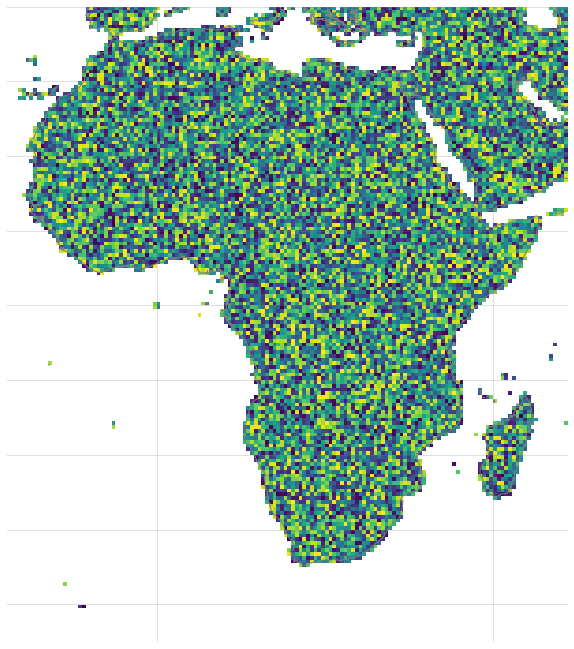

In [43]:
africa.ds['BIG_RANDOM'] = africa.ds['RANDOM'] * 2 

africa.ds['DATA'] = africa.ds['BIG_RANDOM']*africa.ds['LAND']

africa.ds['DATA'] = africa.ds['DATA'].where(africa.ds['DATA'] != 0.)  

africa.map_grid('DATA', cmap='viridis') # We only need to send the label to the function 

Xarray have a number option to index and select data. See details about the API at the [Xarray project page](http://xarray.pydata.org/en/stable/api.html). Here are some examples that hopefully explain the options: 

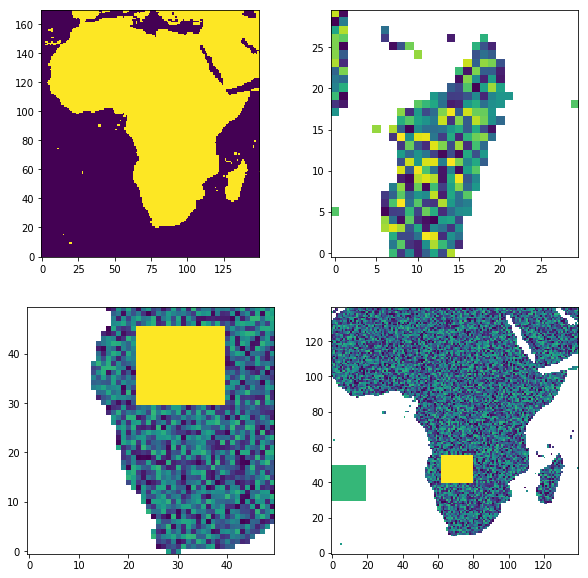

In [44]:
# Values can be assigned
africa.ds['DATA'][dict(X=slice(4, 30), Y=slice(40, 60))] = 2

#modify one grid point, using where() or loc()
africa.ds['DATA'] = xr.where((africa.ds.coords['lat']==-20)&(africa.ds.coords['lon']==30), 2, africa.ds['DATA'])

# Assign value to an area with a mask 
mask = (africa.ds.coords['lat']>-20)&(africa.ds.coords['lat']<-12)&(africa.ds.coords['lon']>16)&(africa.ds.coords['lon']<25)
africa.ds['DATA'] = xr.where(mask, 3, africa.ds['DATA'])

# Data by numpy index:
A =  africa.ds['DATA'][66, 33]

# Coord by index:
B = africa.ds.coords['lon'][66, 33]

# Data by coord using isel:
C = africa.ds['DATA'].isel(X=33, Y=66)

# Closest to coordinate values:
#http://xarray.pydata.org/en/stable/generated/xarray.Dataset.sel.html#xarray.Dataset.sel
D = africa.ds['DATA'].sel(X=[14.5, 71.32], method='nearest') 

# Or another coordinate set:
E = africa.ds.coords['lon'][66, 33]

# Use coordinates to select a slice from a data array:
F = africa.ds['LAND']

# Select 2D array from slices of coordinates from dict of indicies
G = africa.ds['DATA'][dict(X=slice(120, 150), Y=slice(40, 70))]

# Select 2D array from coordinate values
H = africa.ds['DATA'].sel(X=slice(5, 30), Y=slice(-35, -10))

I = africa.ds['DATA'][10:150,10:150]

fig, axes = plt.subplots(2,2, figsize=(10,10))
for ax, array in zip(axes.flatten(), [F, G, H, I]):
    ax.imshow(array, origin='lower')


plt.show()

This returned a cell of the entire dataset, but we can also extract numpy arrays and numbers by using a dictionary interface `values`: 

In [45]:
print(type(africa)) #The agrid Grid object
print(type(africa.ds)) #The dataset
print(type(africa.ds['DATA'])) #A dataarray
print(type(africa.ds['DATA'].values)) #Numpy array from dataarray
print(type(africa.ds['DATA'].values[10,10])) #An element in the array

<class 'agrid.grid.Grid'>
<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataarray.DataArray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>


JSON is a handy format for transferring and store metadata:

In [46]:
# Add attribute data directely
africa.ds.attrs['units'] = 'degrees'
africa.ds.attrs['contact'] = 'mail@address.gh'

#Or as text, xml, json etc
import json
with open('attr.json', 'r') as fp:
    meta_data = json.loads(fp.read())

for item in meta_data.items():
    africa.ds.attrs[item[0]] = item[1]

By using a convenient function to access data, json files are automatically assigned to attribute data for each dataset. 

In [47]:
africa.ds['LAND'].attrs = {'unit': 'm'}

In [48]:
africa.ds['LAND']

<xarray.DataArray 'LAND' (Y: 170, X: 150)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])
Coordinates:
  * X        (X) float32 -20.0 -19.496645 -18.993288 ... 53.99329 54.496643 55.0
  * Y        (Y) float32 -45.0 -44.49704 -43.994083 ... 38.994083 39.49704 40.0
    XV       (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
    YV       (Y, X) float32 -45.0 -45.0 -45.0 -45.0 ... 40.0 40.0 40.0 40.0
    lat      (Y, X) float32 -45.0 -45.0 -45.0 -45.0 ... 40.0 40.0 40.0 40.0
    lon      (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
Attributes:
    unit:     m

Attributes to xarray dataset: 

In [49]:
print('Coords:')
print(africa.ds.coords)

print('Attributes, metadata:')
print(africa.ds.attrs)

print('Size in bytes:')
print(africa.ds.nbytes)

Coords:
Coordinates:
  * X        (X) float32 -20.0 -19.496645 -18.993288 ... 53.99329 54.496643 55.0
  * Y        (Y) float32 -45.0 -44.49704 -43.994083 ... 38.994083 39.49704 40.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * X_edge   (X_edge) float32 -20.25 -19.746666 -19.243334 ... 54.746666 55.25
  * Y_edge   (Y_edge) float32 -45.25 -44.74706 -44.244118 ... 39.74706 40.25
  * Z_edge   (Z_edge) float64 -4e+03 4e+03 1.2e+04 2.8e+04 1.95e+05 5.05e+05
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
    YV       (Y, X) float32 -45.0 -45.0 -45.0 -45.0 ... 40.0 40.0 40.0 40.0
    lat      (Y, X) float32 -45.0 -45.0 -45.0 -45.0 ... 40.0 40.0 40.0 40.0
    lon      (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
Attributes, metadata:
{'units': 'degrees', 'contact': 'name.nameson@email.gh.com', 'continent': 'Africa', 'projection': 4326, 'name': 'Name Nameson'}
Size in bytes:
1048148


We use a function from the class to save. Returns size.  

In [50]:
africa.save(file_name='../data/africa.nc')

1063167

In [51]:
!stat ../data/africa.nc  

16777221 39019454 -rw-r--r-- 1 tobias_stal staff 0 1063167 "Sep 11 11:39:14 2020" "Sep 11 14:37:48 2020" "Sep 11 14:37:48 2020" "Sep 11 11:39:14 2020" 4096 2080 0 ../data/africa.nc


Note that the module have very limited error handling, exceptions are raised by Python and the used models. 

In [52]:
africa.ds['NO_DATA_HERE']

# Raises: "if var_name is None: KeyError: 'NO_DATA'"

KeyError: 'NO_DATA_HERE'

Saving the complete class object using `pickle` can also be handy. Be aware of the [risks with pickle](https://intoli.com/blog/dangerous-pickles/), only open files that you trust. 

In [53]:
import pickle
pickle.dump(africa, open( "../data/africa.p", "wb" ))

Clear memory: 

In [54]:
del africa 

In [55]:
africa = pickle.load( open( "../data/africa.p", "rb" ) )
print(africa.ds)

<xarray.Dataset>
Dimensions:     (RGB: 3, X: 150, X_edge: 151, Y: 170, Y_edge: 171, Z: 5, Z_edge: 6)
Coordinates:
  * X           (X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
  * Y           (Y) float32 -45.0 -44.49704 -43.994083 ... 39.49704 40.0
  * Z           (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * X_edge      (X_edge) float32 -20.25 -19.746666 ... 54.746666 55.25
  * Y_edge      (Y_edge) float32 -45.25 -44.74706 -44.244118 ... 39.74706 40.25
  * Z_edge      (Z_edge) float64 -4e+03 4e+03 1.2e+04 2.8e+04 1.95e+05 5.05e+05
  * RGB         (RGB) <U1 'R' 'G' 'B'
    XV          (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
    YV          (Y, X) float32 -45.0 -45.0 -45.0 -45.0 ... 40.0 40.0 40.0 40.0
    lat         (Y, X) float32 -45.0 -45.0 -45.0 -45.0 ... 40.0 40.0 40.0 40.0
    lon         (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
Data variables:
    RANDOM      (Y, X) float64 0.4135 0.3441 0.6024 ... 0.4626 0.515 0.4495